In [ ]:
! wget https://edinburghnlp.inf.ed.ac.uk/workshops/SemEval2022/train.En.csv

--2022-01-09 17:08:08--  https://edinburghnlp.inf.ed.ac.uk/workshops/SemEval2022/train.En.csv
Resolving edinburghnlp.inf.ed.ac.uk (edinburghnlp.inf.ed.ac.uk)... 129.215.33.77, 2001:630:3c1:33:216:3eff:fee2:6fec
Connecting to edinburghnlp.inf.ed.ac.uk (edinburghnlp.inf.ed.ac.uk)|129.215.33.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491939 (480K) [text/csv]
Saving to: ‘train.En.csv.2’

train.En.csv.2      100%[===================>] 480.41K   658KB/s    in 0.7s    

2022-01-09 17:08:09 (658 KB/s) - ‘train.En.csv.2’ saved [491939/491939]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.read_csv('train.En.csv')
df.dropna(subset=['tweet'], inplace=True)
df.fillna('', inplace=True)
df.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0,1,0,0,0,0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1,0,0,0,0,0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0,1,0,0,0,0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1,0,0,0,0,0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


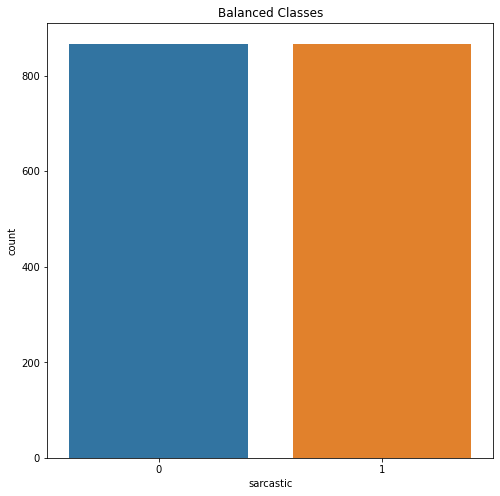

In [ ]:
fraud_df = df.loc[df['sarcastic'] == 1]
non_fraud_df = df.loc[df['sarcastic'] == 0].sample(n=867, random_state=42)
df = pd.concat([fraud_df, non_fraud_df])

plt.figure(figsize=(8, 8))
sns.countplot('sarcastic', data=df)
plt.title('Balanced Classes')
plt.show()

In [ ]:
tweets = df.drop(['sarcastic', 'sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question'], axis=1)
tweets['all'] = tweets['tweet']
tweets.head()
labels = df['sarcastic']
labels.value_counts()

1    867
0    867
Name: sarcastic, dtype: int64

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LeakyReLU

In [ ]:
words = tweets.copy()

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

In [ ]:
def get_corpus(words):
  lemmatizer = WordNetLemmatizer()
  porter = PorterStemmer()
  corpus = []

  for i in range(len(words)):
    try:
      review = re.sub('[^a-zA-Z]', ' ', words.iloc[i])
      review = review.lower()
      review = review.split()
      review = [word for word in review 
                if not word in stopwords.words('english')]
      review = ' '.join(review)
      corpus.append(review)
    except Exception as e:
      print(i)
      print(words['tweet'])
  return corpus

In [ ]:
def tokenize(corpus):
  tokenizer = Tokenizer(num_words=20000)
  tokenizer.fit_on_texts(corpus)
  sequences = tokenizer.texts_to_sequences(corpus)
  word_index = tokenizer.word_index
  max_len = max([len(x) for x in sequences])
  len(word_index)
  return sequences, word_index, max_len

In [ ]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [ ]:
GLOVE_DIR = 'glove.6B.100d.txt'
EMBEDDING_DIM = 100

def get_word_vectors(sequences, word_index):
  embeddings_index = {}

  with open(GLOVE_DIR, 'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      embeddings_index[word] = np.asarray(values[1:], dtype='float32')

  embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      embedding_matrix[i] = np.random.randn(EMBEDDING_DIM)
  return embedding_matrix

In [ ]:
sequences, word_index, max_len = tokenize(get_corpus(words['all']))
data = pad_sequences(sequences, padding='post', maxlen=max_len)
embedding_matrix = get_word_vectors(sequences, word_index)

In [ ]:
len(word_index)
max_len

42

In [ ]:
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Embedding(len(word_index)+1, output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))
model.add(Bidirectional(LSTM(units=16 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
X_processed = np.array(data)
y_processed = np.array(labels)

X_processed.shape, y_processed.shape

((1734, 42), (1734,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, 
                                                    test_size=0.2, random_state=16)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=0, patience=5, mode='auto')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[callback], epochs=100, batch_size=32)


Epoch 1/100
44/44 [==============================] - 9s 93ms/step - loss: 0.7261 - acc: 0.5018 - val_loss: 0.7175 - val_acc: 0.4899
Epoch 2/100
44/44 [==============================] - 4s 80ms/step - loss: 0.7125 - acc: 0.4910 - val_loss: 0.7039 - val_acc: 0.4841
Epoch 3/100
44/44 [==============================] - 4s 81ms/step - loss: 0.7056 - acc: 0.4773 - val_loss: 0.6989 - val_acc: 0.4870
Epoch 4/100
44/44 [==============================] - 4s 80ms/step - loss: 0.7017 - acc: 0.4845 - val_loss: 0.6976 - val_acc: 0.4928
Epoch 5/100
44/44 [==============================] - 4s 81ms/step - loss: 0.7032 - acc: 0.4809 - val_loss: 0.6956 - val_acc: 0.5274
Epoch 6/100
44/44 [==============================] - 4s 80ms/step - loss: 0.7021 - acc: 0.4881 - val_loss: 0.6944 - val_acc: 0.5245
Epoch 7/100
44/44 [==============================] - 4s 80ms/step - loss: 0.6967 - acc: 0.4968 - val_loss: 0.6935 - val_acc: 0.5303
Epoch 8/100
44/44 [==============================] - 4s 81ms/step - loss: 0.

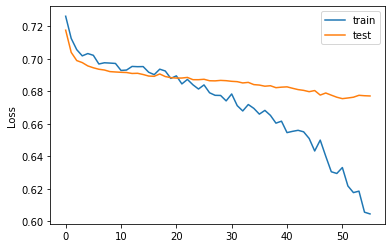

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel=('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

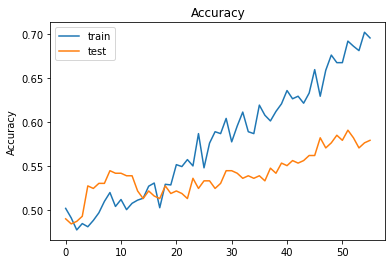

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.xlabel=('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(X_test)
predictions = [1 if i[0] > 0.5 else 0 for i in pred]

cm = confusion_matrix(y_test, predictions)


In [ ]:
cm

array([[ 84,  94],
       [ 52, 117]])

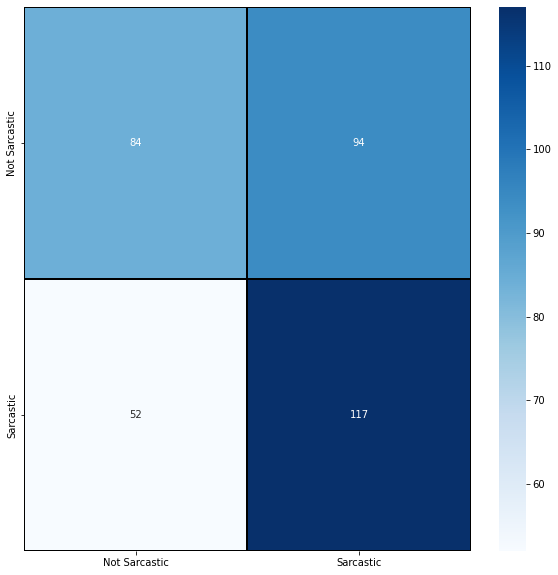

In [ ]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.62      0.47      0.54       178
    Sarcastic       0.55      0.69      0.62       169

     accuracy                           0.58       347
    macro avg       0.59      0.58      0.58       347
 weighted avg       0.59      0.58      0.57       347

